In [1]:
import torch, torchvision, pdb, PIL, os
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [14]:
#vizualization function
def show_tensor_images(image_tensor, num_images=25, name=""):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5).permute(1, 2, 0)
    plt.imshow(image_grid)
    plt.grid(None)
    plt.show()

In [19]:
#hyperparameters and general parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
zdim = 1000
display_step = 35

cur_step = 0
crit_cycles = 5
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35

In [20]:
#generator model
class Generator(nn.Module):
    def __init__(self, zdim=64, d_dim=16):
        super(Generator, self).__init__()
        self.zdim = zdim

        self.gen = nn.Sequential(
            self.make_gen_block(zdim, d_dim*32, 4, 1, 0),
            self.make_gen_block(d_dim*32, d_dim*16, 4, 2, 1),
            self.make_gen_block(d_dim*16, d_dim*8, 4, 2, 1),
            self.make_gen_block(d_dim*8, d_dim*4, 4, 2, 1),
            self.make_gen_block(d_dim*4, d_dim*2, 4, 2, 1),
            self.make_gen_block(d_dim*2, 3, 4, 2, 1, final_layer=True),

        )

    def make_gen_block(self, input_channels, output_channels, kernel_size, stride, padding, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias=False),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.zdim, 1, 1)
        return self.gen(x)
#gen noise
def get_noise(n_samples, zdim, device="cpu"):
    return torch.randn(n_samples, zdim, device=device)

In [21]:
#critic model
class Critic(nn.Module):
    def __init__(self, d_dim=16):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(3, d_dim, 4, 2, 1),
            self.make_crit_block(d_dim, d_dim * 2, 4, 2, 1),
            self.make_crit_block(d_dim * 2, d_dim * 4, 4, 2, 1),
            self.make_crit_block(d_dim * 4, d_dim * 8, 4, 2, 1),
            self.make_crit_block(d_dim * 8, d_dim * 16, 4, 2, 1),
            nn.Conv2d(d_dim*16, 1, 4, 1, 0, bias=False),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(output_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

In [86]:
#load dataset
import gdown, zipfile
url = "https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM"
path = "data/celeba"
download_path = f"{path}/img_align_celeba.zip"
if not os.path.exists(path):
    os.makedirs(path)
#gdown.download(url, download_path, quiet=False)
with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall(path)
os.remove(download_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data/celeba/img_align_celeba.zip'

In [32]:
class CelebADataset(Dataset, path):
    def __init__(self, root_dir, size = 128):
        self.sizes = [size, size]
        items, labels = [], []

        for data in os.listdir(path):
            item = os.path.join(path, data)
            items.append(item)
            labels.append(0)
        self.items = items
        self.labels = labels

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        data = PIL.Image.open(self.items[idx]).convert("RGB")
        data = np.asarray(torchvision.transforms.Resize(self.sizes)(data))
        data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False)
        data = torch.from_numpy(data).div(255)
        return data, self.labels[idx]

#Dataset
dataset = CelebADataset(path, size=128)

#dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [33]:
#gradient penalty
def gradient_penalty(real, fake, crit, alpha, gama=10):
    mix_images = real * alpha + fake * (1 - alpha)
    mix_scores = crit(mix_images)
    gradient = torch.autograd.grad(
        inputs=mix_images,
        outputs=mix_scores,
        grad_outputs=torch.ones_like(mix_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = gama * ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

In [35]:
#save and load checkpoint json
root_path = "data/checkpoints/"
if not os.path.exists(root_path):
    os.mkdir(root_path)
def save_checkpoint(name):
    print("=> Saving checkpoint")
    torch.save({
        "epoch": epoch,
        "gen_state_dict": gen.state_dict(),
        "gen_opt_state_dict": gen_opt.state_dict(),
    }, f"{root_path}G-{name}.pkl")
    torch.save({
        "epoch": epoch,
        "crit_state_dict": crit.state_dict(),
        "crit_opt_state_dict": crit_opt.state_dict(),
    }, f"{root_path}C-{name}.pkl")

def load_checkpoint(name):
    print("=> Loading checkpoint")
    checkpoint = torch.load(f"{root_path}G-{name}.pkl")
    gen.load_state_dict(checkpoint["gen_state_dict"])
    gen_opt.load_state_dict(checkpoint["gen_opt_state_dict"])

    checkpoint = torch.load(f"{root_path}C-{name}.pkl")
    crit.load_state_dict(checkpoint["crit_state_dict"])
    crit_opt.load_state_dict(checkpoint["crit_opt_state_dict"])
    print("=> Loaded checkpoint")


In [36]:
gen = Generator(zdim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


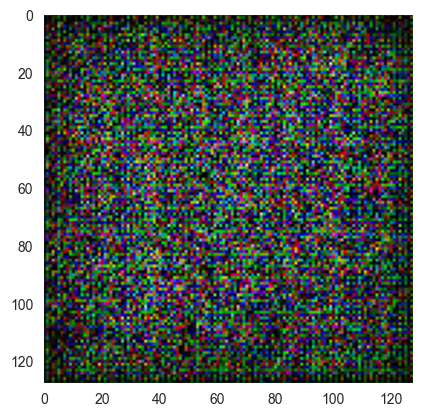

In [41]:
noise = get_noise(1, zdim, device=device)
fake = gen(noise)
show_tensor_images(fake)

In [1]:
#training loop
epochs = 1000
for epoch in range(epochs):
    for real, _ in dataloader:
        cur_bs = len(real)
        real = real.to(device)


        #critc training
        mean_crit_loss = 0
        crit.train()
        for _ in range(crit_cycles):
            crit_opt.zero_grad()

            noise = get_noise(cur_bs, zdim, device=device)
            fake = gen(noise)

            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            alpha = torch.rand(len(real),1,1,1,device=device, requires_grad=True)
            gp = gradient_penalty(real, fake.detach(), crit, alpha)

            crit_loss = (torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + gp)
            mean_crit_loss = crit_loss.item()/crit_cycles

            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        crit_losses += [mean_crit_loss]

        #gen training
        gen.train()
        gen_opt.zero_grad()

        noise = get_noise(BATCH_SIZE, zdim, device=device)
        fake = gen(noise)

        crit_fake_pred = crit(fake)
        gen_loss = -torch.mean(crit_fake_pred)
        gen_loss.backward()
        gen_opt.step()

        gen_losses += [gen_loss.item()]

        #show stats
        cur_step += 1
        if cur_step % display_step == 0 and cur_step > 0:
            mean_gen_loss = sum(gen_losses[-display_step:]) / display_step
            mean_crit_loss = sum(crit_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_gen_loss}, critic loss: {mean_crit_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(gen_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(gen_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss",
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(crit_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss",
            )
            plt.legend()
            plt.show()


NameError: name 'dataloader' is not defined